## Part 2: Data Exploration

In Part 2 of this tutorial, we prepare data files for reciprocal space mapping with _mdx2_ and demonstrate interactive tools for data exploration.

### Importing diffraction data

First, we introduce the _mdx2_ command line programs for importing diffraction images and geometric corrections from _DIALS_ in Part 1. Most features of _mdx2_ needed for the tutorial are available in command-line programs. Run the following program to verify that _mdx2_ is installed and activated:

In [1]:
!mdx2.version

mdx2: 0.3.1


The version number (0.3.1) should be printed.

The first step in the _mdx2_ workflow is to import the diffraction images. Unlike _DIALS_, _mdx2_ does not read diffraction data directly from image files. Instead, the data are imported (i.e. copied) into a three-dimensional array (image stack) and stored in a NeXus-formatted hdf5 file. There are two advantages to this: first, subsequent _mdx2_ programs can be very simple because they don't need to handle diverse image formats, and second, the data can be compressed in a way that improves performance when it is subsequently read. 

The notebook directory should contain the _DIALS_ output files (`refined.expt`). Run the following:

In [2]:
!mdx2.import_data refined.expt --chunks 20 211 493

Exporting <class 'mdx2.data.ImageSeries'> to nexus object
  writing image_series to data.nxs
ImageSet: reading frame 0
ImageSet: reading frame 1
ImageSet: reading frame 2
ImageSet: reading frame 3
ImageSet: reading frame 4
ImageSet: reading frame 5
ImageSet: reading frame 6
ImageSet: reading frame 7
ImageSet: reading frame 8
ImageSet: reading frame 9
ImageSet: reading frame 10
ImageSet: reading frame 11
ImageSet: reading frame 12
ImageSet: reading frame 13
ImageSet: reading frame 14
ImageSet: reading frame 15
ImageSet: reading frame 16
ImageSet: reading frame 17
ImageSet: reading frame 18
ImageSet: reading frame 19
ImageSet: reading frame 20
ImageSet: reading frame 21
ImageSet: reading frame 22
ImageSet: reading frame 23
ImageSet: reading frame 24
ImageSet: reading frame 25
ImageSet: reading frame 26
ImageSet: reading frame 27
ImageSet: reading frame 28
ImageSet: reading frame 29
ImageSet: reading frame 30
ImageSet: reading frame 31
ImageSet: reading frame 32
ImageSet: reading frame 33

The program reads image files (the file path is stored in `refined.expt`) and saves the raw data and associated metadata in the file `data.nxs`. The `--chunks` parameter controls the size of the sub-arrays that will be compressed in the hdf5 file. Chunking allows for reading or writing small segments of the array without decompressing the entire dataset. Here, we chose a size of 20 x 211 x 493. Roughly, 211 x 493 corresponds to panel on the Pilatus 6M, and 20 specifies a stack of 20 frames (2 degrees of rotation). The particular chunk shape is not critical, but it can affect performance of subsequent operations.

Note that operations involving raw image data can be time consuming. Data import may take several minutes. For slow operations, _mdx2_ produces print statements to track its progress. In this case, it prints the frame number as files are being read (0 -- 499). Every 20 frames, the program writes chunks incrementally to the data file (`data.nxs` will increase in size until it reaches approximately 1.1 Gb).

The contents of any nexus file can be viewed using the program `mdx2.tree`. For instance,

In [3]:
!mdx2.tree data.nxs

data.nxs: root:NXroot
  @HDF5_Version = '1.12.2'
  @file_name = '/nfs/chess/user/spm82/mdx/meth-enzymol-tutoria...'
  @file_time = '2023-04-16T11:31:16.513357'
  @h5py_version = '3.7.0'
  @nexusformat_version = '0.7.8'
  entry:NXentry
    image_series:NXdata
      @axes = ['phi', 'iy', 'ix']
      @mdx2_class = 'ImageSeries'
      @mdx2_module = 'mdx2.data'
      @signal = 'data'
      data = int32(500x2527x2463)
      exposure_times = float64(500)
      ix = float64(2463)
      iy = float64(2527)
      phi = float64(500)


### Importing diffraction geometry

The next step is to import the geometric information necessary to map each pixel to its location in reciprocal space. Run the following program:

In [4]:
!mdx2.import_geometry refined.expt

Computing miller index lookup grid
Computing geometric correction factors
Gathering space group info
Gathering unit cell info
Saving geometry to geometry.nxs
Exporting <class 'mdx2.geometry.Crystal'> to nexus object
  writing crystal to geometry.nxs
Exporting <class 'mdx2.geometry.Symmetry'> to nexus object
  writing symmetry to geometry.nxs
Exporting <class 'mdx2.geometry.Corrections'> to nexus object
  writing corrections to geometry.nxs
Exporting <class 'mdx2.geometry.MillerIndex'> to nexus object
  writing miller_index to geometry.nxs
done!


The output file `geometry.nxs` contains crystal lattice information, symmetry operators, and pre-computed arrays of correction factors and Miller indices. To conserve disk space, the array values are not computed at every pixel, but instead on coarser grid. The grid parameters can be changed from the default values using the optional `--sample_spacing` argument. Help text for any `mdx2` program can be printed by adding `--help`. For instance,

In [5]:
!mdx2.import_geometry --help

usage: mdx2.import_geometry [-h] [--sample_spacing PHI IY IX]
                            [--outfile OUTFILE]
                            expt

Import experimental geometry using the dxtbx machinery

positional arguments:
  expt                  dials experiments file, such as refined.expt

options:
  -h, --help            show this help message and exit
  --sample_spacing PHI IY IX
                        inverval between samples in degrees or pixels
                        (default: [1, 10, 10])
  --outfile OUTFILE     name of the output NeXus file (default: geometry.nxs)


Under "optional arguments" above, the help text explains that the default interval for sampling is every 1 degree of rotation and every 10 pixels on the detector.

The contents of `geometry.nxs` can be viewed using `mdx2.tree` as above. However, the output is limited to the metadata such as the array types and sizes. Much more information is available using _NeXpy_. For instance, to view the solid angle correction, follow these steps:

- In the terminal type `nexpy` to launch the program
- Click `File > open`, navigate to your working directory
- Open `geometry.nxs`
- Expand the tree in the left panel to locate `solid_angle`.
- Double-click it to plot.

The solid angle per pixel (steradian units) should be displayed as a colormap on the detector surface as shown below:

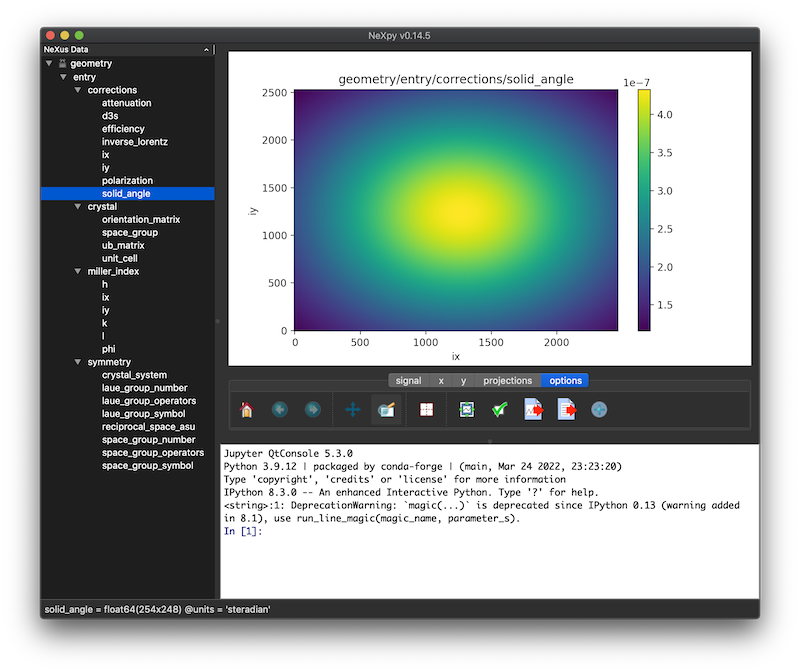

### Calculating a rocking curve in Python

Finally, we demonstrate how saving diffraction data in NeXus files can enable rapid data exploration in Python. The following lines in Python are all that is needed to plot a rocking curve for an intense reflection:

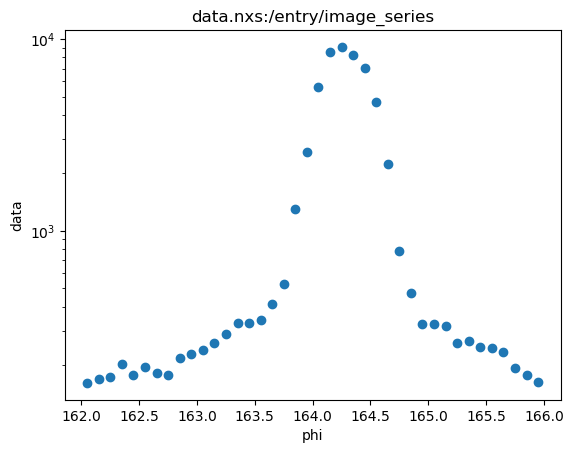

In [6]:
from nexusformat.nexus import nxload
image_series = nxload('data.nxs')['/entry/image_series']
image_series.project(0,limits=((20,60),(1215,1225),(2080,2090))).logplot()

Further examples of working with NeXus files in Python can be found in the [nexusformat documentation](http://nexpy.github.io/nexpy/pythonshell.html).